In [1]:
!pip install duckdb --no-index --find-links=file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg

Looking in links: file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
Processing /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg/duckdb-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import polars as pl
import duckdb as dd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from pydicom import dcmread
import warnings

## Conditions
### spinal_canal_stenosis
### neural_foraminal_narrowing
#### left/right
### subarticular_stenosis
#### left/right

## Levels of vertebrae
#### l1_l2
#### l2_l3
#### l3_l4
#### l4_l5
#### l5_s1

> Each Study has series of images for these three conditions. The series description tells us what type of image is in the dcm file

In [3]:
train_meta_data = pl.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv'\
                              , low_memory=True)
train_series_desc = pl.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv'\
                                , low_memory=True)
train_label_coordinates = pl.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv'\
                                      , low_memory=True)

In [ ]:
"""dd.sql("select series_description, count(distinct(study_id)) as studies, count(distinct(series_id)) as series \
from train_series_desc group by series_description").pl()"""

In [4]:
pl.Config(fmt_str_lengths=100)
pl.Config.set_tbl_rows(1000)
print(train_meta_data.filter(pl.col('study_id')==100206310).transpose(include_header=True))
print(train_series_desc.filter(pl.col('study_id')==100206310))
print(train_label_coordinates.filter(pl.col('study_id')==100206310))

shape: (26, 2)
┌────────────────────────────────────────┬─────────────┐
│ column                                 ┆ column_0    │
│ ---                                    ┆ ---         │
│ str                                    ┆ str         │
╞════════════════════════════════════════╪═════════════╡
│ study_id                               ┆ 100206310   │
│ spinal_canal_stenosis_l1_l2            ┆ Normal/Mild │
│ spinal_canal_stenosis_l2_l3            ┆ Normal/Mild │
│ spinal_canal_stenosis_l3_l4            ┆ Moderate    │
│ spinal_canal_stenosis_l4_l5            ┆ Severe      │
│ spinal_canal_stenosis_l5_s1            ┆ Normal/Mild │
│ left_neural_foraminal_narrowing_l1_l2  ┆ Normal/Mild │
│ left_neural_foraminal_narrowing_l2_l3  ┆ Moderate    │
│ left_neural_foraminal_narrowing_l3_l4  ┆ Moderate    │
│ left_neural_foraminal_narrowing_l4_l5  ┆ Severe      │
│ left_neural_foraminal_narrowing_l5_s1  ┆ Moderate    │
│ right_neural_foraminal_narrowing_l1_l2 ┆ Moderate    │
│ right_neural_f

In [13]:
dcm_image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1012284084/20.dcm'
left_centre_coords = (int(180.355677), int(165.0342))
right_centre_coords = (int(145.120536), int(162.285714))
radius = 10
color = (255, 0, 0)  # Red color in BGR
thickness = 2

dicom_ds = dcmread(dcm_image_path)
IMG = dicom_ds.pixel_array

IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

left_IMG_with_circle = cv2.circle(IMG_normalized.copy(), left_centre_coords, radius, color, thickness)
left_IMG_with_circle = cv2.cvtColor(left_IMG_with_circle, cv2.COLOR_BGR2RGB)

right_IMG_with_circle = cv2.circle(IMG_normalized.copy(), right_centre_coords, radius, color, thickness)
right_IMG_with_circle = cv2.cvtColor(right_IMG_with_circle, cv2.COLOR_BGR2RGB)

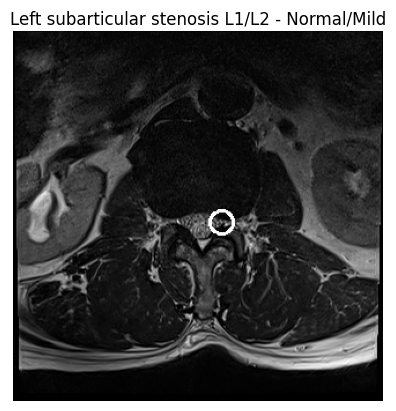

In [14]:
plt.imshow(left_IMG_with_circle)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Left subarticular stenosis L1/L2 - Normal/Mild")
plt.show()

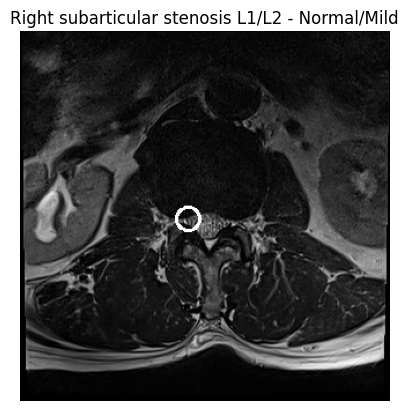

In [15]:
plt.imshow(right_IMG_with_circle)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Right subarticular stenosis L1/L2 - Normal/Mild")
plt.show()

In [16]:
dcm_image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1012284084/46.dcm'
left_centre_coords = (int(168.536252), int(156.27907))
right_centre_coords = (int(146.263393), int(160.0))
radius = 10
color = (255, 0, 0)  # Red color in BGR
thickness = 2

dicom_ds = dcmread(dcm_image_path)
IMG = dicom_ds.pixel_array

IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

left_IMG_with_circle = cv2.circle(IMG_normalized.copy(), left_centre_coords, radius, color, thickness)
left_IMG_with_circle = cv2.cvtColor(left_IMG_with_circle, cv2.COLOR_BGR2RGB)

right_IMG_with_circle = cv2.circle(IMG_normalized.copy(), right_centre_coords, radius, color, thickness)
right_IMG_with_circle = cv2.cvtColor(right_IMG_with_circle, cv2.COLOR_BGR2RGB)

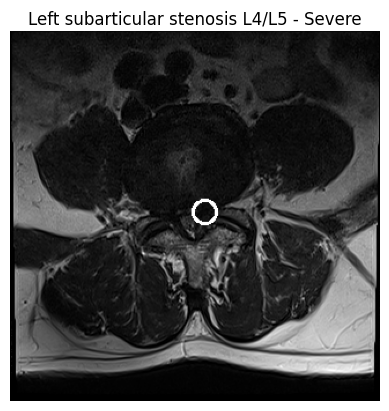

In [17]:
plt.imshow(left_IMG_with_circle)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Left subarticular stenosis L4/L5 - Severe")
plt.show()

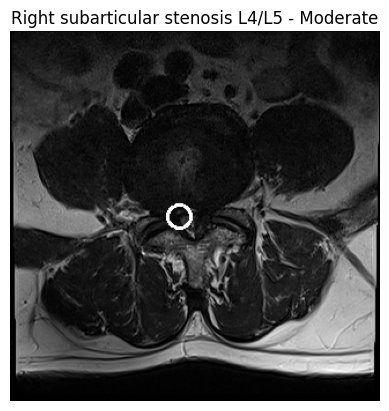

In [18]:
plt.imshow(right_IMG_with_circle)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Right subarticular stenosis L4/L5 - Moderate")
plt.show()

In [19]:
dcm_image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/2092806862/4.dcm'
right_centre_coords = (int(253.393075), int(278.680244))
radius = 10
color = (255, 0, 0)  # Red color in BGR
thickness = 2

dicom_ds = dcmread(dcm_image_path)
IMG = dicom_ds.pixel_array

IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

right_IMG_with_circle = cv2.circle(IMG_normalized.copy(), right_centre_coords, radius, color, thickness)
right_IMG_with_circle = cv2.cvtColor(right_IMG_with_circle, cv2.COLOR_BGR2RGB)

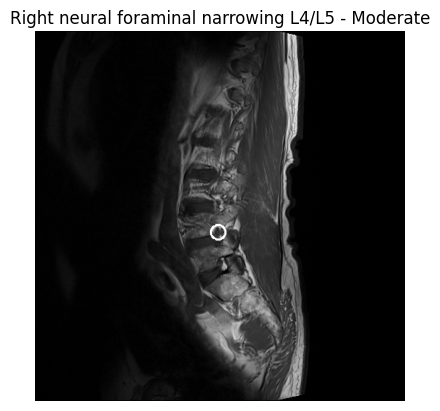

In [20]:
plt.imshow(right_IMG_with_circle)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Right neural foraminal narrowing L4/L5 - Moderate")
plt.show()

In [ ]:
submission = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/sample_submission.csv')
submission['row_id'] = 'samples'

In [ ]:
import glob
import os

config = {}
config['root_file_path'] = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/'

studies = os.listdir(config['root_file_path'])

In [ ]:
rows = {}
weight_dict = {'normal_mild':1, 'moderate':2, 'severe':4}
conditions = ['spinal_canal_stenosis', 'neural_foraminal_narrowing', 'subarticular_stenosis']
sides = ['left', 'right']
vertebrae_levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']
severity_levels = ['normal_mild', 'moderate', 'severe']

for c in conditions:
    for v in vertebrae_levels:
        if c != 'spinal_canal_stenosis':
            for s in sides:
                for st in studies:
                    #print(st+'_'+s+'_'+c+'_'+v)
                    rows[st+'_'+s+'_'+c+'_'+v] = np.array([0.333333 * 2, 0.333333 * 2, 0.333333 * 2])
        else:
            for st in studies:
                #print(st+'_'+c+'_'+v)
                rows[st+'_'+c+'_'+v] = np.array([0.333333 * 2, 0.333333 * 2, 0.333333 * 2])

In [ ]:
for row_id, feature in tqdm(rows.items()):
    feature_set_reshaped = feature.reshape(1, -1)
    predictions = np.ascontiguousarray(feature_set_reshaped/2)
    df = pd.DataFrame(predictions, columns=severity_levels)
    df.insert(loc=0, column='row_id', value=row_id)
    submission = pd.concat([submission,df]).reset_index(drop=True)
    
i = submission[(submission.row_id == 'samples')].index
submission = submission.drop(i).reset_index(drop=True)

In [ ]:
submission.to_csv('submission.csv', index=False)